In [40]:
# default_exp pointsource

In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Pointsource
> This module contain diffrent samplers for generation point sources

In [42]:
from pathlib import Path
from nbdev_template.utils import *
import torch
import inspect
from nbdev.showdoc import *
from fastcore.test import *
import numpy as np
import matplotlib.pyplot as plt
from nbdev_template.transforms import *

In [43]:
#export
import torch
from nbdev_template.transforms import *

In [44]:
TRN_IMG_3D_P = Path('/nrs/turaga/smlm_data/SvobodaWang_mFISH/sample.ALM.tif')
TRN_IMG_3D = torch.tensor(tiff_imread(TRN_IMG_3D_P).astype('float32'));
TRN_IMG_3D = TRN_IMG_3D.permute(1, 0, 2, 3)

In [45]:
data_min = TRN_IMG_3D.min()
data_max = TRN_IMG_3D.max()
low      = torch.tensor(0.001)
high     = torch.tensor(0.05)

In [46]:
scaler = ScaleTensor(low=low, high=high, data_min = data_min, data_max = data_max)
scaler

Transform(ScaleTensor)
low: 0.0010000000474974513
high: 0.05000000074505806
data_min: 176.0
data_max: 3169.0


In [47]:
crop_sz = (101, 100, 100)
rand_crop = RandomCrop3D(TRN_IMG_3D.shape, crop_sz)
rand_crop

Transform(RandomCrop3D)
img_sz: (101, 960, 960)
crop_sz: (101, 100, 100)


In [48]:
M = rand_crop(scaler(TRN_IMG_3D))

In [49]:
M.shape

torch.Size([3, 101, 100, 100])

In [50]:
#export
class PointSourceGaussian(TransfromBase):
    """
    Sample Point Source from Gaussina and Binomial Distribution
    
    \n This class is part of generative model and uses probility density map `m` to generate 
    locations `loc`  `x`, `y`, `z` offsets and `ints` intensity of emitters. `m` should be 
    `torch.tensor` scaled from 0.001 to 1, which is used by `_sample_bin` to generate `0` and
    `1` . `0` means that we dont have emitter at given pixel and 1 means emitters is presnet. This
    map is used to generate offset in `x`, `y`, `z` and intensities which tells how bright is emitter
    or in same casses how many emitters are bound to RNA molecules.
    
    
    \nParameters:
    \n`min_int`     : minimum intensity of emitters

    \nReturns:
    \n`locs`: locations of the emitters
    \n`x_os`: x offset of the emitters
    \n`y_os`: y offset of the emitters
    \n`z_os`: z offset of the emitters
    \n`ints`: z intensity of the emitters
    
    
    """

    def __init__(self, min_int: float):
        self.min_int = min_int
    
    def __call__(self, m):
        super().__call__(m)
        dev = self._get_device(m)
        zeros = torch.zeros_like(m)
        locs  = self._sample_bin(1, m).to(dev)
        x_os  = self._sample_uni(zeros-0.5, zeros+0.5).to(dev)
        y_os  = self._sample_uni(zeros-0.5, zeros+0.5).to(dev)
        z_os  = self._sample_uni(zeros-0.5, zeros+0.5).to(dev)
        ints  = self._sample_uni(zeros+self.min_int, torch.ones_like(zeros)).to(dev)
        x_os *= locs
        y_os *= locs
        z_os *= locs
        ints *= locs
        return locs, x_os, y_os, z_os, ints
    
    @staticmethod
    def _sample_uni(low, high):
        return getattr(torch.distributions, 'Uniform')(low=low, high=high).sample()
    
    @staticmethod
    def _sample_bin(total_count, probs, **kwargs):
        return getattr(torch.distributions, 'Binomial')(total_count=total_count, probs=probs, **kwargs).sample()
    


In [51]:
show_doc(PointSourceGaussian)

<h2 id="PointSourceGaussian" class="doc_header"><code>class</code> <code>PointSourceGaussian</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>PointSourceGaussian</code>(**`min_int`**:`float`) :: [`TransfromBase`](/nbdev_template/transforms#TransfromBase)

    Sample Point Source from Gaussina and Binomial Distribution
    
    
 This class is part of generative model and uses probility density map `m` to generate 
    locations `loc`  `x`, `y`, `z` offsets and `ints` intensity of emitters. `m` should be 
    `torch.tensor` scaled from 0.001 to 1, which is used by `_sample_bin` to generate `0` and
    `1` . `0` means that we dont have emitter at given pixel and 1 means emitters is presnet. This
    map is used to generate offset in `x`, `y`, `z` and intensities which tells how bright is emitter
    or in same casses how many emitters are bound to RNA molecules.
    
    
    
Parameters:
    
`min_int`     : minimum intensity of emitters

    
Returns:
    
`locs`: locations of the emitters
    
`x_os`: x offset of the emitters
    
`y_os`: y offset of the emitters
    
`z_os`: z offset of the emitters
    
`ints`: z intensity of the emitters
    
    
    

In [52]:
min_int=0.4
point_source = PointSourceGaussian(min_int)
point_source

Transform(PointSourceGaussian)
min_int: 0.4


In [53]:
test_eq(callable(point_source), True)
test_eq(point_source.min_int, min_int)
test_eq(len(point_source(M)), 5)
test_eq(M.device, point_source(M)[0].device)
test_eq(M.cuda().device, point_source(M.cuda())[0].device)
test_eq(M.cuda().device, point_source(M.cuda())[1].device)
test_eq(M.cuda().device, point_source(M.cuda())[2].device)
test_eq(M.cuda().device, point_source(M.cuda())[3].device)
test_eq(M.cuda().device, point_source(M.cuda())[4].device)
test_eq((point_source(M)[0].min(), point_source(M)[0].max()), (0, 1))
test_eq(list(map(lambda x: getattr(x, 'size')(), point_source(M))), [M.shape] *5)

In [54]:
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d = point_source(M)

In [55]:
list(map(lambda x: getattr(x, 'size')(), [locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d,]))

[torch.Size([3, 101, 100, 100]),
 torch.Size([3, 101, 100, 100]),
 torch.Size([3, 101, 100, 100]),
 torch.Size([3, 101, 100, 100]),
 torch.Size([3, 101, 100, 100])]

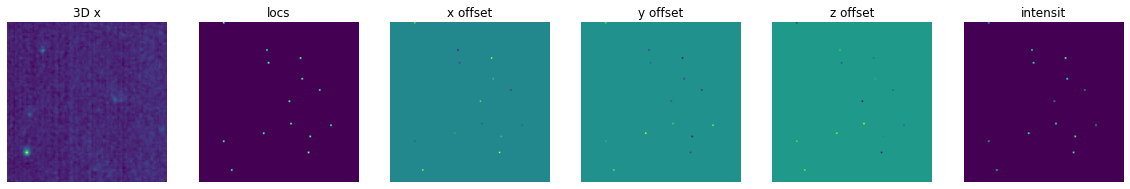

In [56]:
idx = 1
ch = 1
fig, axes = plt.subplots(1, 6, figsize=(20, 20))
show_image(M      .permute(1, 0, 2, 3)[:, ch, :, :][idx], title= '3D x'    , ax = axes[0])
show_image(locs_3d.permute(1, 0, 2, 3)[:, ch, :, :][idx], title= 'locs'    , ax = axes[1])
show_image(x_os_3d.permute(1, 0, 2, 3)[:, ch, :, :][idx], title= 'x offset', ax = axes[2])
show_image(y_os_3d.permute(1, 0, 2, 3)[:, ch, :, :][idx], title= 'y offset', ax = axes[3])
show_image(z_os_3d.permute(1, 0, 2, 3)[:, ch, :, :][idx], title= 'z offset', ax = axes[4])
show_image(ints_3d.permute(1, 0, 2, 3)[:, ch, :, :][idx], title= 'intensit', ax = axes[5])

In [57]:
from nbdev.export import *
notebook2script()

Converted 00_models.ipynb.
Converted 01_simulation.ipynb.
Converted index.ipynb.
Converted pointsource.ipynb.
Converted transforms.ipynb.
Converted utils.ipynb.
